# Ensemble Methods for Regression

We have see how to choose between competing machine learning models. However, we don't have to choose! It is usually better to combine predictions from several models than to use the prediction from the single best model. This notebook investigates methods for combining predictions from different regression models. Methods for combining predictions from different machine learning models are called _ensemble methods_.

We'll continue using the Ames housing data, using features **Gr Liv Area**, **Bedroom AbvGr**, and **Full Bath** to predict **SalePrice**.

In [1]:
import pandas as pd

import numpy as np

In [2]:
df_housing = pd.read_csv("http://dlsun.github.io/pods/data/AmesHousing.txt", sep="\t")

X_train = df_housing[["Gr Liv Area", "Bedroom AbvGr", "Full Bath"]]
y_train = df_housing["SalePrice"]

First, we fit two models to predict house price: a linear regression model and a $10$-nearest neighbors model. Then we use each of the models to predict the price of a a 1500 sqft, 2BR/2BA house.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Train linear regression model
linear_model = LinearRegression()
linear_model.fit(X=X_train, y=y_train)

# Train 10-nearest neighbors model
knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=10)
)
knn_model.fit(X=X_train, y=y_train)

# Predict for a 1500 sqft, 2BR/2BA house
new_house = [[1500, 2, 2]]
linear_model.predict(new_house), knn_model.predict(new_house)

/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(array([217919.89318936]), array([229259.]))

The $k$-nearest neighbors model predicts a larger price than the linear regression model. How should we reconcile these two different predictions?

## Voting

The simplest ensemble method is _voting_. To apply voting to regression models, we simply average the predictions from the different models. So the predicted quality of a 1500 sqft, 2BR/2BA house is:

In [4]:
import numpy as np
np.mean([
    linear_model.predict(new_house),
    knn_model.predict(new_house)
])

/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


223589.44659468165

We can also specify the voting ensemble in scikit-learn, using `VotingRegressor`.

In [5]:
from sklearn.ensemble import VotingRegressor

ensemble_model = VotingRegressor([
    ("linear", linear_model),
    ("knn", knn_model)
])
ensemble_model.fit(X=X_train, y=y_train)
ensemble_model.predict(new_house)

/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([223589.44659468])

How good is this ensemble model? Is it better than each model individually? We let cross-validation decide, using 5-fold cross-validation.

In [6]:
from sklearn.model_selection import cross_val_score

for model in [linear_model, knn_model, ensemble_model]:
    print(-cross_val_score(model, X=X_train, y=y_train, cv=5,
                           scoring="neg_mean_squared_error").mean())

2694147782.5379286
2439435755.1347885
2406743430.23774


Remember that these errors are large because the metric is the mean *squared* error (MSE). To obtain a more interpretable metric, we can take the square root to obtain the RMSE. However, for the purposes of determining which model is best, we just need to know which value is smallest. The ensemble model has a lower MSE than either model individually, even though it simply averages the predictions from the two models. This example illustrates the power of ensembling.

By default, `VotingRegressor` computes a simple average of the predictions. The `weights` parameter can be used to specify weights $c_1, \ldots, c_M$ given to each of the $M$ models so that the predicted label is a weighted average of the $M$ predictions.

$$ \hat y = c_1 \hat y_1 + \ldots + c_M \hat y_M $$

In [7]:
# 40% weight to linear regression; 60% weight for KNN
ensemble_model_weighted = VotingRegressor([
    ("linear", linear_model),
    ("knn", knn_model)],
    weights = [0.4, 0.6]
)
ensemble_model_weighted.fit(X=X_train, y=y_train)
ensemble_model_weighted.predict(new_house)

/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([224723.35727575])

## Stacking

In voting, every model's prediction gets equal weight, or a predefined weight (which can be specified using the `weights=` parameter of `VotingRegressor`). Another approach, called _stacking_ , **learns** the weights $c_1, \ldots, c_M$ given to each of the $M$ models so that the predicted label

$$ \hat y = c_1 \hat y_1 + \ldots + c_M \hat y_M $$

is as close to the true label as possible.

We already know how to fit a model of this form. We fit linear regression to predict the same label $y$, but the features are now the *predictions* $\hat y_1, \ldots, \hat y_M$ from the individual models.

For example, to learn the weights that should be given to the linear regression and 10-nearest neighbors models above, we first stack the predictions into an array with two columns: the first columns has the predictions from the linear regression model, the second from $k$-nearest neighbors model.

In [8]:
preds = np.stack([
    linear_model.predict(X_train), knn_model.predict(X_train)
], axis=1)
preds

array([[179976.84549368, 161120.        ],
       [119672.36873575, 108065.        ],
       [141137.57264119, 135475.        ],
       ...,
       [ 98497.51467775, 115065.        ],
       [178228.21435129, 134590.        ],
       [247342.99092085, 262469.        ]])

Now, we train a linear regression model on these predictions.

In [9]:
stacker = LinearRegression()
stacker.fit(X=preds, y=y_train)

LinearRegression()

The description of stacking above, while conceptually correct, is not quite accurate. In practice, to prevent overfitting, each prediction in `preds` is calculated using a model that was trained on different data. In order to evaluate ensemble models, we need to cross-validate the entire process:

1.  Fit each individual model to the training set.
1.  Fit a final model on the predictions on the training set (for
stacking).
1.  Make predictions on the validation set.

The full details are beyond the scope of this course. Fortunately, scikit-learn handles most of the details.

In [11]:
from sklearn.ensemble import StackingRegressor

stacking_model = StackingRegressor([
    ("linear", linear_model),
    ("knn", knn_model)],
    final_estimator=LinearRegression()
)
stacking_model.fit(X=X_train, y=y_train)

stacker = stacking_model.final_estimator_
stacker.intercept_, stacker.coef_

(277.7042949357128, array([0.30067628, 0.69896079]))

In other words, the combined prediction is

$$ \widehat{\text{SalePrice}} = 262.7 + 0.298 \cdot (\text{linear regression prediction}) + 0.702 \cdot (\text{$10$-nearest neighbors prediction}). $$

Contrast this with voting, which gave equal weight (i.e., $0.50$) to the two predictions.

How well does stacking do? Again, we use cross-validation to evaluate.

In [12]:
-cross_val_score(stacking_model, X=X_train, y=y_train, cv=5,
                 scoring="neg_mean_squared_error").mean()

2390886907.924657

This is the best model we've seen so far. The error is even lower than the voting ensembler.

## Some Intuition for Ensemble Methods

Why do ensemble methods work so well? Let's consider a model with just one feature **Gr Liv Area** (sqft). The plot below displays the data, along with the regression functions from the linear regression model, the $k$-nearest neighbors model, and the ensemble model.

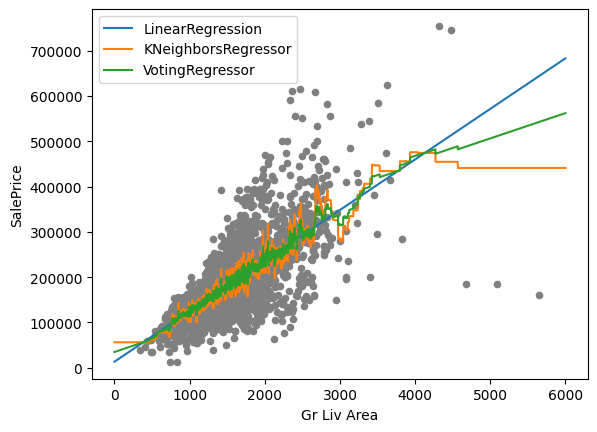

In [13]:
df_housing.plot.scatter(x="Gr Liv Area", y="SalePrice", color="gray")

X_train = df_housing[["Gr Liv Area"]]
y_train = df_housing["SalePrice"]

for model in [LinearRegression(),
              KNeighborsRegressor(n_neighbors=10),
              ensemble_model]:
    model.fit(X=X_train, y=y_train)
    X_test = pd.DataFrame({"Gr Liv Area": np.arange(6000)})
    predictions = pd.Series(
        model.predict(X_test),
        index=X_test["Gr Liv Area"]
    )
    predictions.plot.line(legend=True, label=type(model).__name__)

We see that the ensemble model combines the best features of $k$-nearest neighbors and linear regression.

- Like $k$-nearest neighbors, it is able to model nonlinear relationships (such as the pattern near 3000 sqft).
- Like linear regression, it is able to extrapolate near the boundaries of the data range. (Contrast this with $k$-nearest neighbors, which produces predictions that are constant near the boundaries.) (Also be careful: we're saying the linear regression extrapolates better near the boundary *within* the range of the data; we don't want to extrapolate far beyond the range of the data.)

This is why the ensemble model is often superior to each model individually.

## Caution when judging the value of MSE

Suppose you have a model for which the test error, measured as MSE, is close to 0. Is this necessarily a good model? Pause to think before proceeding.

The answer is no, for two reasons. The first is that MSE depends on the (squared) measurement units of the target variable. More importantly, MSE must be judged relative to the variance of the target variable. Consider a model which just predicts the mean of the target variable for every observation, regardless of the values of the features. Then the MSE of this model would just be the variance of the target variable. So if the target has little variance, then just predicting the mean for every observation is pretty effective!

Therefore, we can consider the variance of the target variable as a rough benchmark when evaluating MSE (or the standard deviation of the target variable as a rough benchmark for RMSE). If the test error of a particular model is not a substantial improvement over the variance of the target, then the model isn't much more effective than just predicting the mean for every observation.

In [14]:
y_train.var()

6381883615.6884365

We see that the ensemble models we have fit do provide a substantial reduction in MSE relative to the variance of the target.



Technically, due to train versus test set considerations, the variance of the target for the training data isn't quite the benchmark. We can use `DummyRegressor` in scikit-learn to see what the test error would be for a model that just predicts the mean (of the training data) for every observation. Note that we would never actually use `DummyRegressor` as a practical model; it just gives a benchmark for comparison.

In [15]:
from sklearn.dummy import DummyRegressor

mean_model = DummyRegressor(strategy="mean")

-cross_val_score(mean_model, X=X_train, y=y_train, cv=5,
                           scoring="neg_mean_squared_error").mean()

6406895302.778119